In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from utils.conn_data import load_pickle
from portfolio_tools.Diagnostics import Diagnostics
from functionals.Functionals import Functionals

warnings.filterwarnings('ignore')
plt.rcParams['lines.linewidth'] = 1

In [7]:
# parameters
train = True
strategy_name = "etfstsm_moskowitz"
delete_files = [".DS_Store", "del_dirs.sh", "inti.py", "init.py"]
diag = Diagnostics()

strategy_name = f"training_{strategy_name}" if train else strategy_name

# paths
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
dirs = sorted(os.listdir(os.path.join(outputs_path, strategy_name)))
dirs = [d for d in dirs if d not in delete_files]

print(dirs)

['MaxDD_means_0.05_10000', 'MaxDD_means_0.15_10000', 'MaxDD_means_0.1_10000', 'MaxDD_means_0.25_10000', 'MaxDD_means_0.2_10000', 'MaxDD_means_0.35_10000', 'MaxDD_means_0.3_10000', 'MaxDD_means_0.45_10000', 'MaxDD_means_0.4_10000', 'MaxDD_means_0.55_10000', 'MaxDD_means_0.5_10000', 'MaxDD_means_0.65_10000', 'MaxDD_means_0.6_10000', 'MaxDD_means_0.75_10000', 'MaxDD_means_0.7_10000', 'MaxDD_means_0.85_10000', 'MaxDD_means_0.8_10000', 'MaxDD_means_0.95_10000', 'MaxDD_means_0.9_10000', 'MaxDD_means_1_10000', 'Sharpe_means_0.05_10000', 'Sharpe_means_0.15_10000', 'Sharpe_means_0.1_10000', 'Sharpe_means_0.25_10000', 'Sharpe_means_0.2_10000', 'Sharpe_means_0.35_10000', 'Sharpe_means_0.3_10000', 'Sharpe_means_0.45_10000', 'Sharpe_means_0.4_10000', 'Sharpe_means_0.55_10000', 'Sharpe_means_0.5_10000', 'Sharpe_means_0.65_10000', 'Sharpe_means_0.6_10000', 'Sharpe_means_0.75_10000', 'Sharpe_means_0.7_10000', 'Sharpe_means_0.85_10000', 'Sharpe_means_0.8_10000', 'Sharpe_means_0.95_10000', 'Sharpe_means

In [8]:
plot = False
windows = range(30, 377 + 1, 1)

all_results = []
for dir in dirs:

    utility = dir.split("_")[0]

    functional = dir.split("_")[1]
    alpha = dir.split("_")[2] # percentile of the empirical distribution - x such that P(X <= x) = alpha
    Bsize = dir.split("_")[3]

    functionals = Functionals(alpha=float(alpha))

    if plot:
        print(f"Utility: {utility}, Functional: {functional}, Alpha: {alpha}, Bsize: {Bsize}")

    # # list files in directory
    # os.listdir(os.path.join(outputs_path, strategy_name, dir))

    optmization_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_opt_results.pickle"))
    portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_portfolio_results.pickle"))
    portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, dir, "test_portfolio_results.pickle"))

    # apply functional to vector of utility vectors
    utilities_val_train = functionals.means(x=optmization_train["utilities"])

    # get the chosen utility vector
    chosen_utility_vector_train = functionals.apply_functional(x=optmization_train["utilities"], func=functional)

    # compute robust utility
    # robust_utility_train = chosen_utility_vector_train.mean()

    # find position of scores that match final_utility
    position = functionals.find_utility_position(utilities=optmization_train["utilities"], utility_value=chosen_utility_vector_train)

    # find window that matches position
    robust_parameter = windows[position]

    # portfolio results
    robust_utility_train = diag.compute_metric(portoflio_returns=portfolio_train['agg_scaled_portfolio_returns'], metric_name=utility)
    robust_utility_test = diag.compute_metric(portoflio_returns=portfolio_test['agg_scaled_portfolio_returns'], metric_name=utility)

    # save results
    round_digits = 2 if utility != '% Positive Ret.' else 4
    results = {
        "Utility": utility,
        "Functional": functional,
        "Alpha": alpha,
        "Bsize": Bsize,
        "Robust Parameter": robust_parameter,
        "Train Utility Mean": np.round(utilities_val_train.mean().item(), round_digits),
        "Train Utility Std": np.round(utilities_val_train.std().item(), round_digits),
        "Robust Train Utility": np.round(robust_utility_train, round_digits),
        "Robust Test Utility": np.round(robust_utility_test, round_digits),
        "Generalization Gap": np.round((robust_utility_test / robust_utility_train - 1)*100, round_digits).item(),
    }

    results_df = pd.DataFrame([results])
    all_results.append(results_df)

    # plot
    utility_val_df = pd.DataFrame(utilities_val_train, columns=[utility])

    if plot:
        ax = sns.histplot(data=utility_val_df, palette="deep")

        plt.axvline(x=utilities_val_train.mean().item(), color='red', linestyle='--', label='Mean', linewidth=0.8)
        plt.axvline(x=robust_utility_train, color='black', linestyle='--', label='Robust Train Utility', linewidth=0.8)
        plt.axvline(x=robust_utility_test, color='green', linestyle='--', label='Robust Test Utility', linewidth=0.8)
        plt.legend(fontsize=8)
        plt.title(f"Histogram for Traning {dir.split('_')[0]} Utilities: alpha={alpha}", size=10)

        plt.show()
all_results_df = pd.concat(all_results)
all_results_df["Alpha"] = ["max" if val == "1.0" else val for val in all_results_df["Alpha"]]

In [9]:
all_results_df.sort_values(by=["Bsize", "Alpha"])

,Utility,Functional,Alpha,Bsize,Robust Parameter,Train Utility Mean,Train Utility Std,Robust Train Utility,Robust Test Utility,Generalization Gap
0,MaxDD,means,0.05,10000,81,-24.21,0.61,-18.26,-7.68,-57.93
0,Sharpe,means,0.05,10000,32,0.14,0.03,0.22,-0.33,-246.71
0,Sortino,means,0.05,10000,32,0.19,0.04,0.29,-0.43,-250.72
0,MaxDD,means,0.1,10000,40,-24.21,0.61,-12.70,-13.03,2.63
0,Sharpe,means,0.1,10000,36,0.14,0.03,0.35,-0.27,-176.70
0,Sortino,means,0.1,10000,36,0.19,0.04,0.46,-0.35,-176.21
0,MaxDD,means,0.15,10000,52,-24.21,0.61,-15.99,-11.10,-30.58
0,Sharpe,means,0.15,10000,39,0.14,0.03,0.40,0.12,-69.61
0,Sortino,means,0.15,10000,39,0.19,0.04,0.52,0.17,-67.82
0,MaxDD,means,0.2,10000,37,-24.21,0.61,-13.00,-18.57,42.79


In [10]:
df_filtered = all_results_df.copy()
df_filtered.loc[df_filtered['Alpha'] == 'max', 'Alpha'] = 1.0
df_filtered['Alpha'] = pd.to_numeric(df_filtered['Alpha'])
df_filtered["Generalization Gap Abs"] = df_filtered["Generalization Gap"].abs()

utilities = df_filtered['Utility'].unique()
Bsizes = df_filtered['Bsize'].sort_values().unique()

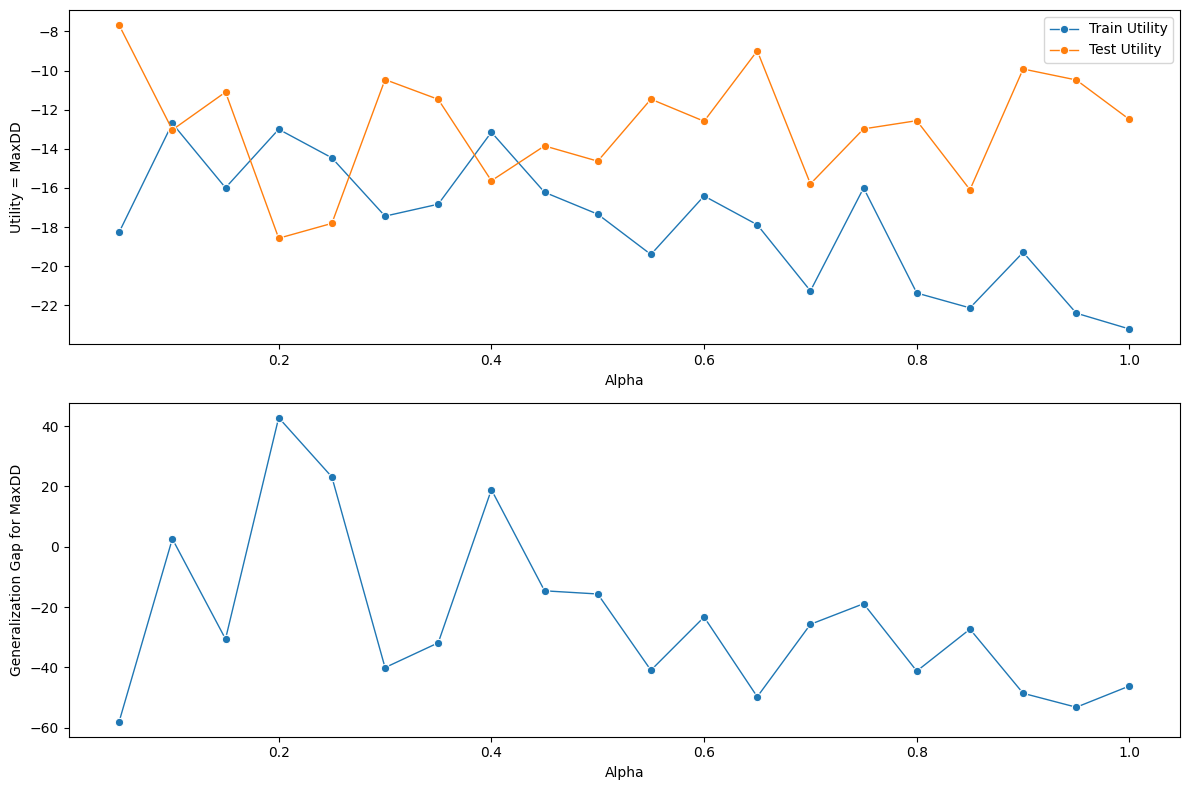

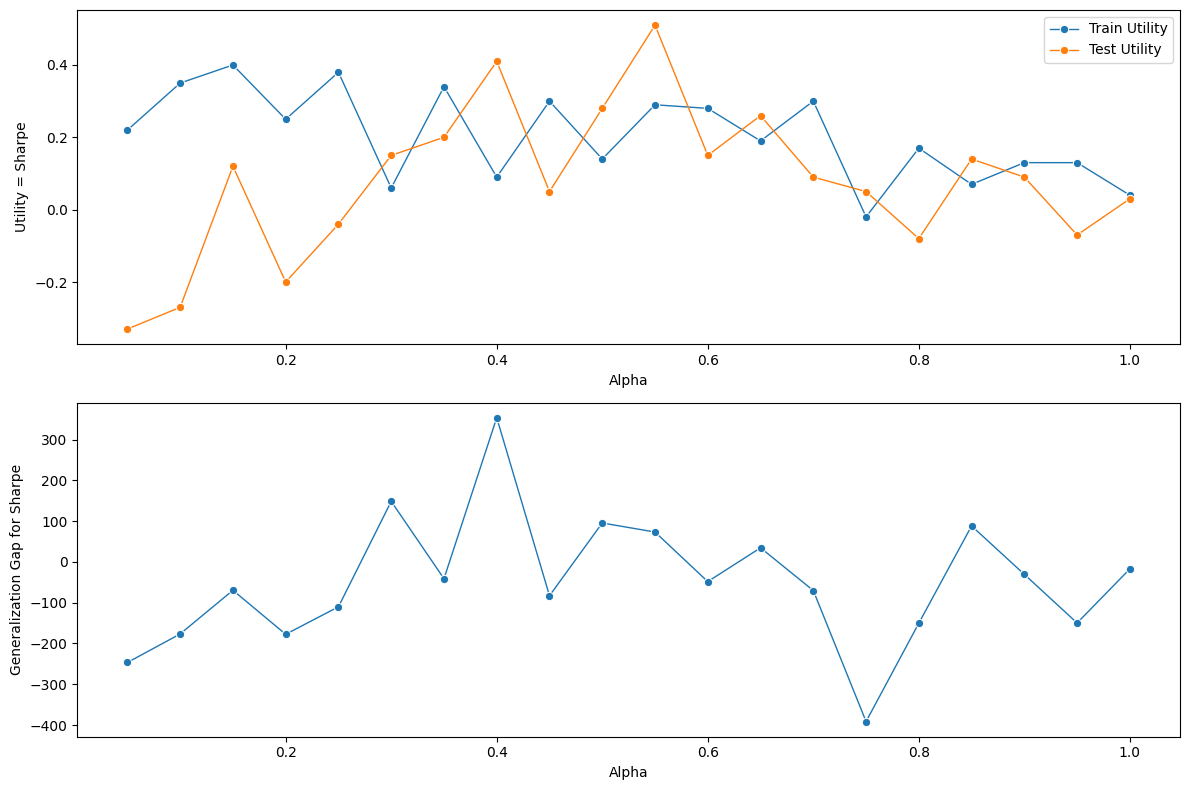

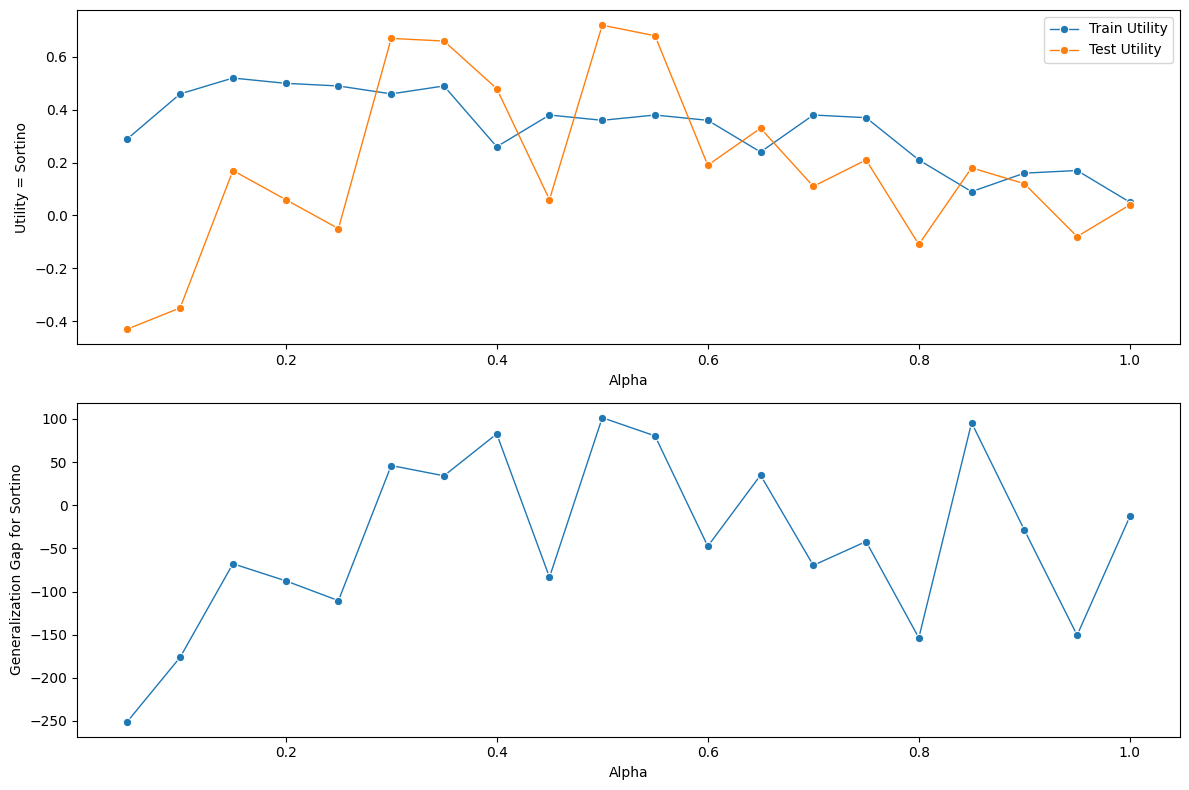

In [19]:
# Plotting
for utility in utilities:
    for Bsize in ['10000']: # Bsizes:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

        plot_df = df_filtered[(df_filtered['Utility'] == utility) & (df_filtered['Bsize'] == Bsize)]
        
        # Subplot 1: Robust Train and Test Utility vs Alpha for each Bsize
        sns.lineplot(data=plot_df, x='Alpha', y='Robust Train Utility', ax=axes[0], marker='o', label='Train Utility')
        sns.lineplot(data=plot_df, x='Alpha', y='Robust Test Utility', ax=axes[0], marker='o', label='Test Utility')
        # axes[0].set_title(f'{utility} and Bsize={Bsize}: Train and Test Utility vs Alpha')
        axes[0].set_xlabel('Alpha')
        axes[0].set_ylabel(f'Utility = {utility}')
        
        # Subplot 2: Generalization Gap vs Alpha for each Bsize
        sns.lineplot(data=plot_df, x='Alpha', y='Generalization Gap', ax=axes[1], marker='o')
        # axes[1].set_title(f'Generalization Gap vs Alpha for {utility}')
        axes[1].set_xlabel('Alpha')
        axes[1].set_ylabel(f'Generalization Gap for {utility}')

        plt.tight_layout()

        # save image
        plt.savefig(os.path.join(outputs_path, 'results', f'{utility.lower()}-gap-utility.png'))

        plt.show()

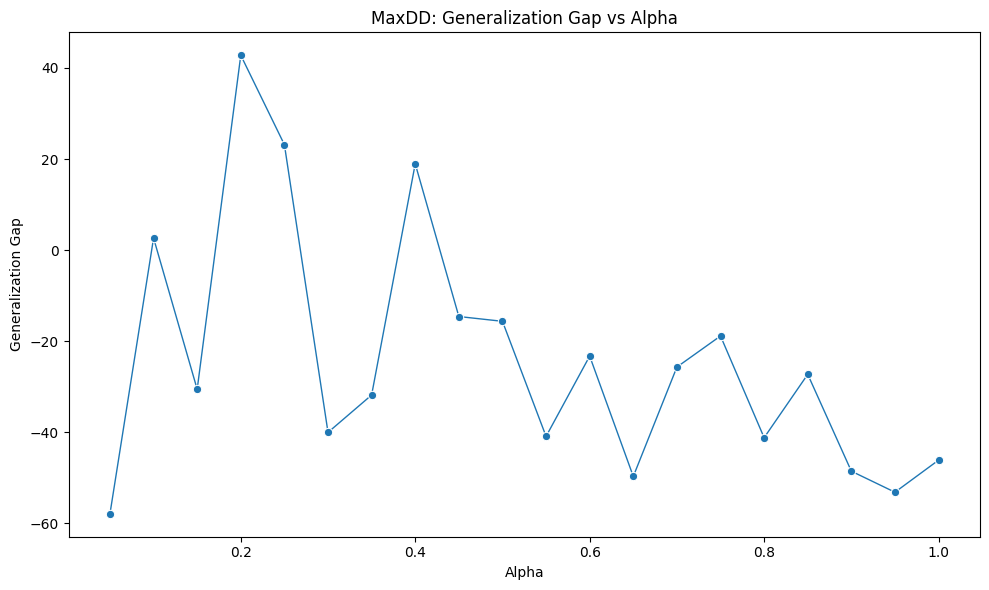

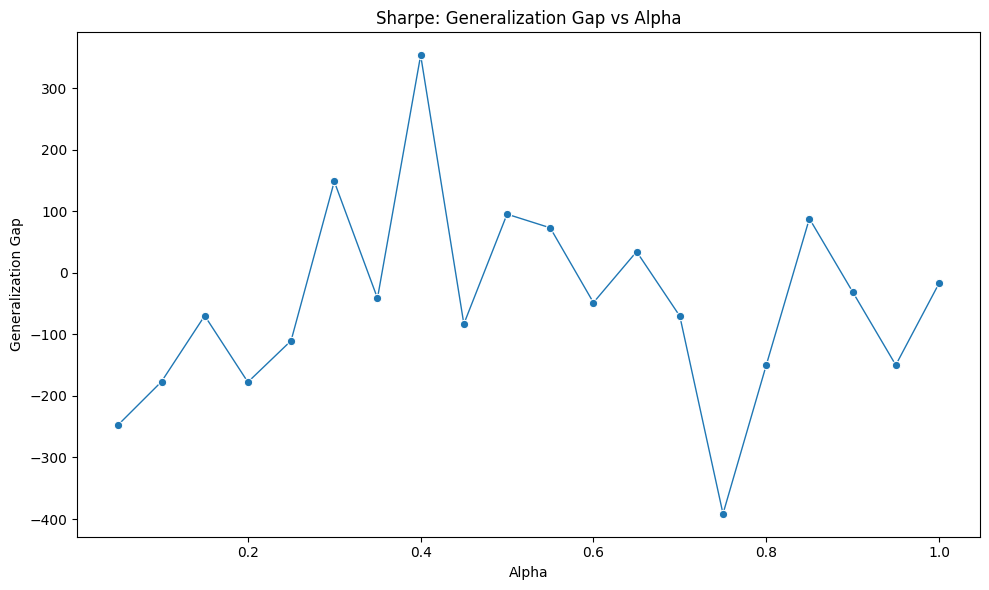

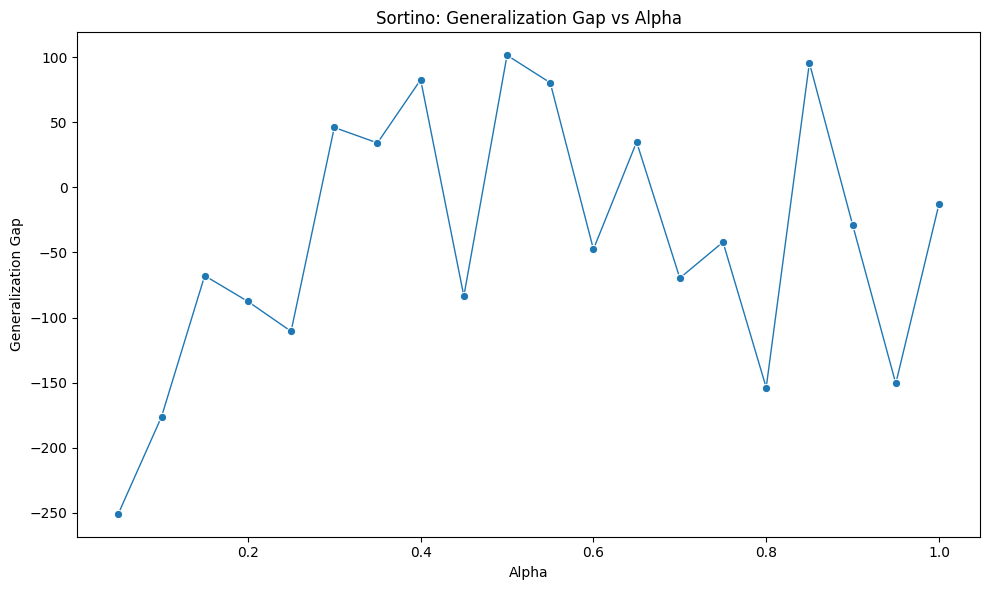

In [12]:
# Plotting
for utility in utilities:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot: Generalization Gap vs Alpha for each Bsize
    sns.lineplot(data=df_filtered[df_filtered['Utility'] == utility], x='Alpha', y='Generalization Gap', ax=ax, marker='o')
    ax.set_title(f'{utility}: Generalization Gap vs Alpha')
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Generalization Gap')

    plt.tight_layout()
    plt.show()

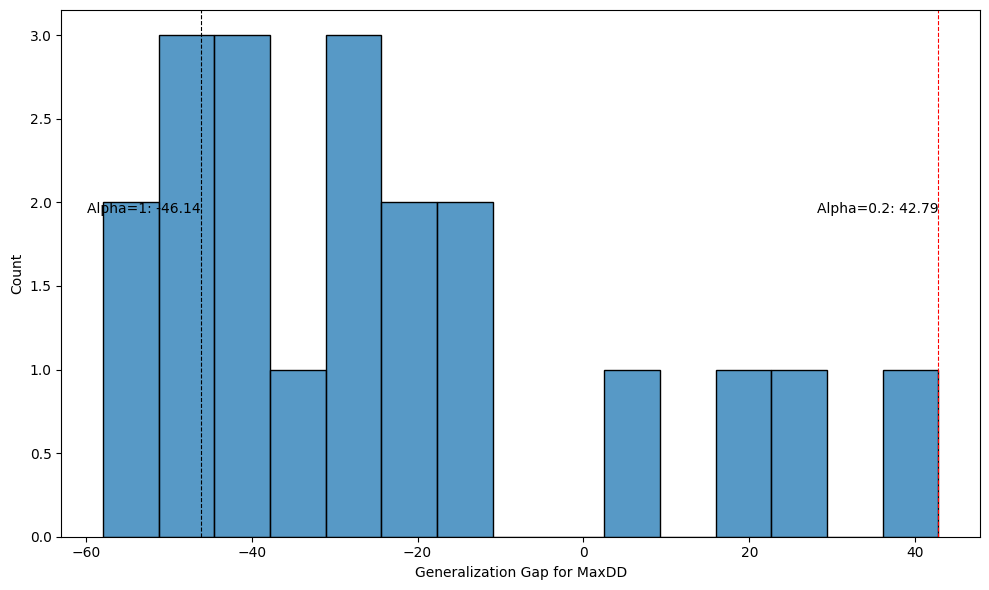

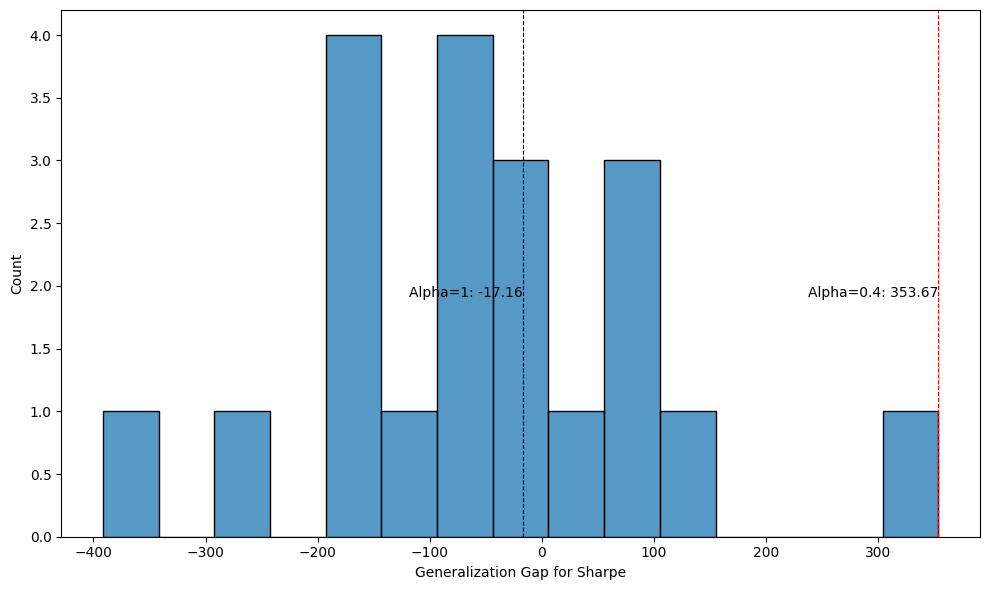

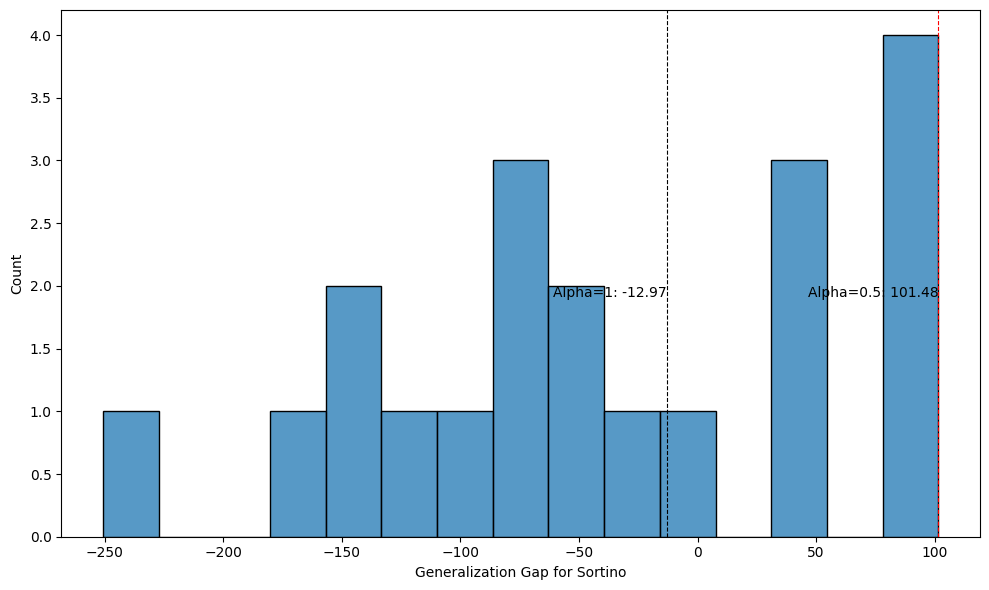

In [20]:
# Plotting
for utility in utilities:
    fig, ax = plt.subplots(figsize=(10, 6))

    hist_df = df_filtered[df_filtered['Utility'] == utility]
    max_Bsize = df_filtered[df_filtered['Utility'] == utility]["Bsize"].max()
    hist_df = hist_df[hist_df["Bsize"] == max_Bsize]
    
    # Plot: Generalization Gap vs Alpha for each Bsize
    sns.histplot(data=hist_df, x='Generalization Gap', ax=ax, bins=15)
    # ax.set_title(f'{utility}: Generalization Gap Histogram')
    ax.set_xlabel(f'Generalization Gap for {utility}')

    # add vertical dashed line for alpha=1
    alpha_1_gap = hist_df.loc[hist_df["Alpha"] == 1]["Generalization Gap"].iloc[0]
    ax.axvline(alpha_1_gap, color='black', linestyle='--', label='Alpha=1', linewidth=0.8)
    ax.text(alpha_1_gap, 2, f'Alpha=1: {alpha_1_gap}', fontsize=10, ha='right', va='top')

    # add vertical dashed the alpha associated with the max generalization gap
    max_generalization_gap = hist_df["Generalization Gap"].max()
    alpha_max_gap = hist_df.loc[hist_df["Generalization Gap"] == max_generalization_gap]["Alpha"].iloc[0]
    ax.axvline(max_generalization_gap, color='red', linestyle='--', label='Alpha=1', linewidth=0.8)
    ax.text(max_generalization_gap, 2, f'Alpha={alpha_max_gap}: {max_generalization_gap}', fontsize=10, ha='right', va='top')

    plt.tight_layout()

    # save image
    plt.savefig(os.path.join(outputs_path, 'results', f'{utility.lower()}-gap-hist.png'))
    
    plt.show()

In [14]:
Bsize = '10000'
utility = 'Sharpe'

selected_results = all_results_df.loc[all_results_df['Bsize'] == Bsize].copy()

utility_selected_results = selected_results.loc[selected_results['Utility'] == utility]

max_sharpe_param = utility_selected_results.loc[utility_selected_results['Alpha'] == '1']['Robust Parameter'].iloc[0]
p25_sharpe_param = utility_selected_results.loc[utility_selected_results['Alpha'] == '0.25']['Robust Parameter'].iloc[0]
p75_sharpe_param = utility_selected_results.loc[utility_selected_results['Alpha'] == '0.75']['Robust Parameter'].iloc[0]
p95_sharpe_param = utility_selected_results.loc[utility_selected_results['Alpha'] == '0.95']['Robust Parameter'].iloc[0]

max_dir = f'{utility}_means_1_{Bsize}'
max_portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, max_dir, "train_portfolio_results.pickle"))
max_portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, max_dir, "test_portfolio_results.pickle"))
max_portfolio_returns_train = max_portfolio_train['agg_scaled_portfolio_returns']
max_portfolio_returns_test = max_portfolio_test['agg_scaled_portfolio_returns']

p25_dir = f'{utility}_means_0.25_{Bsize}'
p25_portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, p25_dir, "train_portfolio_results.pickle"))
p25_portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, p25_dir, "test_portfolio_results.pickle"))
p25_portfolio_returns_train = p25_portfolio_train['agg_scaled_portfolio_returns']
p25_portfolio_returns_test = p25_portfolio_test['agg_scaled_portfolio_returns']

p75_dir = f'{utility}_means_0.75_{Bsize}'
p75_portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, p75_dir, "train_portfolio_results.pickle"))
p75_portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, p75_dir, "test_portfolio_results.pickle"))
p75_portfolio_returns_train = p75_portfolio_train['agg_scaled_portfolio_returns']
p75_portfolio_returns_test = p75_portfolio_test['agg_scaled_portfolio_returns']

p95_dir = f'{utility}_means_0.95_{Bsize}'
p95_portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, p95_dir, "train_portfolio_results.pickle"))
p95_portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, p95_dir, "test_portfolio_results.pickle"))
p95_portfolio_returns_train = p95_portfolio_train['agg_scaled_portfolio_returns']
p95_portfolio_returns_test = p95_portfolio_test['agg_scaled_portfolio_returns']

train_portfolio_returns = pd.concat([
    max_portfolio_returns_train,
    p25_portfolio_returns_train,
    p75_portfolio_returns_train,
    p95_portfolio_returns_train
], axis=1)
train_portfolio_returns.columns = ['max', 'p25', 'p75', 'p95']

test_portfolio_returns = pd.concat([
    max_portfolio_returns_test,
    p25_portfolio_returns_test,
    p75_portfolio_returns_test,
    p95_portfolio_returns_test
], axis=1)
test_portfolio_returns.columns = ['max', 'p25', 'p75', 'p95']

<Axes: title={'center': 'Train Portfolio Returns for Sharpe - Bsize=10000'}, xlabel='date'>

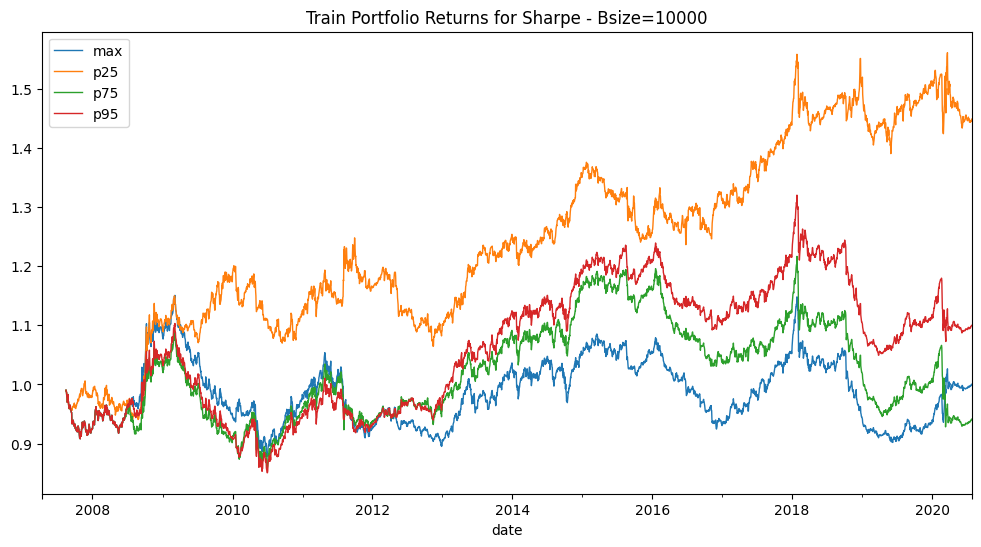

In [15]:
(1+train_portfolio_returns).cumprod().plot(figsize=(12, 6), title=f"Train Portfolio Returns for {utility} - Bsize={Bsize}")


In [16]:
portfolio_train['agg_scaled_portfolio_returns']

,portfolio_returns
date,
2007-04-12,NaN
2007-04-13,NaN
2007-04-16,NaN
2007-04-17,NaN
2007-04-18,NaN
...,...
2020-07-21,0.001483
2020-07-22,-0.000061
2020-07-23,0.000172
